In [16]:
import pandas as pd
import numpy as np
from os import path, makedirs
from glob import glob
from astropy.io import fits
from astropy.wcs import WCS
from skimage.io import imsave
from skimage.transform import resize
import matplotlib.pyplot as plt

In [17]:
images_list = list()
resized=list()
tgt_dim = (120,120)

fits_data_dir = "New_Kahn_fits\\raw\\"

galaxyzoo = pd.read_csv("C:\\Users\\awe2\\DL_DES-master\\data\\sdss-galaxyzoo\\high_certainty\\sdss_metadata\\metadata-bat0008.csv")
print(galaxyzoo.keys())

Index(['Unnamed: 0', 'objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run',
       'rerun', 'camcol', 'field', 'petroRad_r', 'target'],
      dtype='object')


In [18]:
RA_array = galaxyzoo['ra'].values
DEC_array = galaxyzoo['dec'].values
OBJID_array = galaxyzoo['objid'].values
PETROR_array = galaxyzoo['petroRad_r'].values

In [19]:
def clip_img_from_fits(fits_path, ra, dec, rad, pxl_size=0.396, dim=2):
    """
    Extract a small square image containing the target galaxy from a large telescope image.
    
    Parameters:
    fits_path -- path to the input FITS file. This assumes the image data is contained in
                 the 0th entry of the FITS file.
    ra, dec   -- position of the galaxy in the sky.
    rad       -- angular radius of the galaxy in arcseconds.
    pxl_size  -- the size of each pixel in arcseconds. The SDSS FITS files come in 0.396"
                 (see http://classic.sdss.org/dr7/instruments/imager/).
    dim       -- the size of the bounding box in unit of `side_length / galaxy_diameter`.
    
    Returns:
    The clipped galaxy image as a 2d numpy array.
    """
    ds = fits.open(fits_path)
    w = WCS(ds[0].header, ds)
    rad_pxl = rad / pxl_size
    # index naming: r/c: row/col; c/s/e: center/start/end
    cc, rc = w.all_world2pix([[ra, dec]], 1)[0]
    rs, re = [rc + sign * dim * rad_pxl for sign in (-1, 1)]
    cs, ce = [cc + sign * dim * rad_pxl for sign in (-1, 1)]
    rs, re, cs, ce = [int(round(x)) for x in (rs, re, cs, ce)]
    clip = ds[0].data[rs:re, cs:ce]
    return clip

In [20]:
def rescale(img_in, filters=('u', 'g', 'r', 'i', 'z')):
    out = {}
    for f in filters:
        img = img_in[f].astype('float')
        img_bg_sorted = np.sort(img)[:img.size // 2]
        img_bg_std = img_bg_sorted.std()
        img_bg_mean = img_bg_sorted.mean()
        img_min = - img_bg_std + img_bg_mean
        img_max = img_bg_std * 5 + img_bg_mean
        img_scaled = (img - img_min) / (img_max - img_min)
        img_scaled[img_scaled < 0] = 0
        img_scaled[img_scaled > 1] = 1
        out[f] = img_scaled
    return out


def merge_pseudocolor(ds, filters):
    nrows, ncols = ds[list(ds.keys())[0]].shape
    rgb = np.empty((nrows, ncols, 5))
    rgb[:, :, 0] = ds[filters[0]]
    rgb[:, :, 1] = ds[filters[1]]
    rgb[:, :, 2] = ds[filters[2]]
    rgb[:, :, 3] = ds[filters[3]]
    rgb[:, :, 4] = ds[filters[4]]
    rgb = (rgb * 255).astype('uint8')
    return rgb


def process_image(npz_in):
    ds = npz_in
    #ds = np.load(npz_in)
    scaled = rescale(ds, ('u','g','r','i','z'))
    rgb = merge_pseudocolor(scaled, ('u','g','r','i','z'))
    #imsave(png_out, rgb)
    return(rgb)
    

In [21]:
#i need each RA and DEC of the galaxy. we will do this for a few in our directory then stop and start a download of just high
#certainty classified. we will also then just delete all the other fits files. I will also need a way to match these RA and DEC
#to the filenames I have downloaded, which means using the function to take objid-> downloads
def SDSS_objid_to_files_in_dir(objid):
    bin_objid = bin(objid)
    bin_objid = bin_objid[2:len(bin_objid)]
    bin_objid = bin_objid.zfill(64)

    empty = int( '0b' + bin_objid[0], base=0)
    skyVersion = int( '0b' + bin_objid[1:4+1], base=0)
    rerun = int( '0b' + bin_objid[5:15+1], base=0)
    run = int( '0b' + bin_objid[16:31+1], base=0)
    camcol = int( '0b' + bin_objid[32:34+1], base=0)
    firstField = int( '0b' + bin_objid[35+1], base=0)
    field = int( '0b' + bin_objid[36:47+1], base=0)
    object_num = int( '0b' + bin_objid[48:63+1], base=0)

    #return skyVersion, rerun, run, camcol, field, object_num
    return(['run{}-rerun{}-camrol{}-field{}-z.fits'.format(run, rerun, camcol, field), \
            'run{}-rerun{}-camrol{}-field{}-i.fits'.format(run, rerun, camcol, field), \
            'run{}-rerun{}-camrol{}-field{}-r.fits'.format(run, rerun, camcol, field), \
            'run{}-rerun{}-camrol{}-field{}-g.fits'.format(run, rerun, camcol, field), \
            'run{}-rerun{}-camrol{}-field{}-u.fits'.format(run, rerun, camcol, field)])

<h3> MAKE SURE TO CHANGE THE ARRAY_OUT_NAME TO NOT OVERWRITE OTHER IMAGES!!!!</h3>

In [22]:
tgt_dim = (120,120)
start=0
for j,OBJID in enumerate(OBJID_array):
    images_list=list()
    resized=list()
    break_set = False
    
    
    
    for file in (SDSS_objid_to_files_in_dir(OBJID)):
        try:
            images_list.append(clip_img_from_fits(fits_data_dir+file,RA_array[j+start],DEC_array[j+start],PETROR_array[j+start]))
        except Exception as e:
            print('error,', j+start)
            break_set = True
            break
    if break_set == True:
        continue

    
    for k in range(len(images_list)):
        
        if np.shape(images_list[k]) == (0,0) or np.any(np.isnan(images_list[k])): #I demand all 5 bands be correct, and no nans
            print('error,', j+start)
            break_set = True
            break
        
        try:    
            test = (resize(images_list[k],tgt_dim))
            resized.append(test)
        
        except Exception as e:
            print('error,', j+start)
            break_set = True
            break
    
    if break_set == True:
        continue
    

    
    img_in = {'z':resized[0],'r':resized[1],'i':resized[2],'g':resized[3],'u':resized[4]}

    array_out_name = 'HP_{}'.format(str(j+40000).zfill(5))
    scaled = rescale(img_in, ('u','g','r','i','z'))
    img_out = merge_pseudocolor(scaled, ('u','g','r','i','z'))
    np.save('HP_inputs\\{}.npy'.format(array_out_name),img_out) #I messed up here and so will continue like this, but 
                                                                #filter 3 and 4 need to be switched. We can do this in post on 
                                                                #all images.

error, 26
error, 27
error, 28
error, 29
error, 30
error, 31
error, 32
error, 33
error, 34
error, 35
error, 36
error, 37
error, 38
error, 39
error, 40
error, 41
error, 42
error, 43
error, 44
error, 45
error, 46
error, 47
error, 48
error, 49
error, 50
error, 51
error, 52
error, 53
error, 54
error, 55
error, 361
error, 436
error, 437
error, 438
error, 439
error, 440
error, 441
error, 460
error, 462
error, 604
error, 605
error, 606
error, 607
error, 608
error, 609
error, 610
error, 611
error, 612
error, 613
error, 614
error, 615
error, 616
error, 617
error, 618
error, 619


[[[  0   0   0   3   0]
  [  0   0   0   3   0]
  [  0   0   0   3   0]
  ...
  [  0   0   0   3   0]
  [  0   0   0   3   0]
  [  0   0   0   3   0]]

 [[  0   0   0   3   0]
  [ 60  35  22  32  41]
  [107  30  25  40  32]
  ...
  [ 30   8  35  34  39]
  [ 82  21  36  28  22]
  [  0   0   0   3   0]]

 [[  0   0   0   3   0]
  [ 47  38  30  40  55]
  [ 25  22  34  32  43]
  ...
  [ 56  11  39  32  78]
  [103  17  38  36  44]
  [  0   0   0   3   0]]

 ...

 [[  0   0   0   3   0]
  [  9  22  25  29  64]
  [ 18  10  22  40  55]
  ...
  [ 93  44  29  32  70]
  [ 62  48  35  24  76]
  [  0   0   0   3   0]]

 [[  0   0   0   3   0]
  [ 45  45  35  37  37]
  [ 37  31  30  35  26]
  ...
  [121  52  29  35  30]
  [ 75  54  35  23  37]
  [  0   0   0   3   0]]

 [[  0   0   0   3   0]
  [  0   0   0   3   0]
  [  0   0   0   3   0]
  ...
  [  0   0   0   3   0]
  [  0   0   0   3   0]
  [  0   0   0   3   0]]]


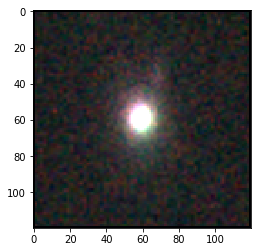

In [23]:
img = np.load('HP_inputs\\HP_29000.npy')
print(img)
plt.imshow(img[:,:,1:4])